In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
root = '/gdrive/My Drive/Biometry/'
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.morphology import skeletonize
from skimage import img_as_bool
from scipy.spatial.distance import cityblock as manhattan_dist
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /gdrive
/gdrive


#Morphological Operations

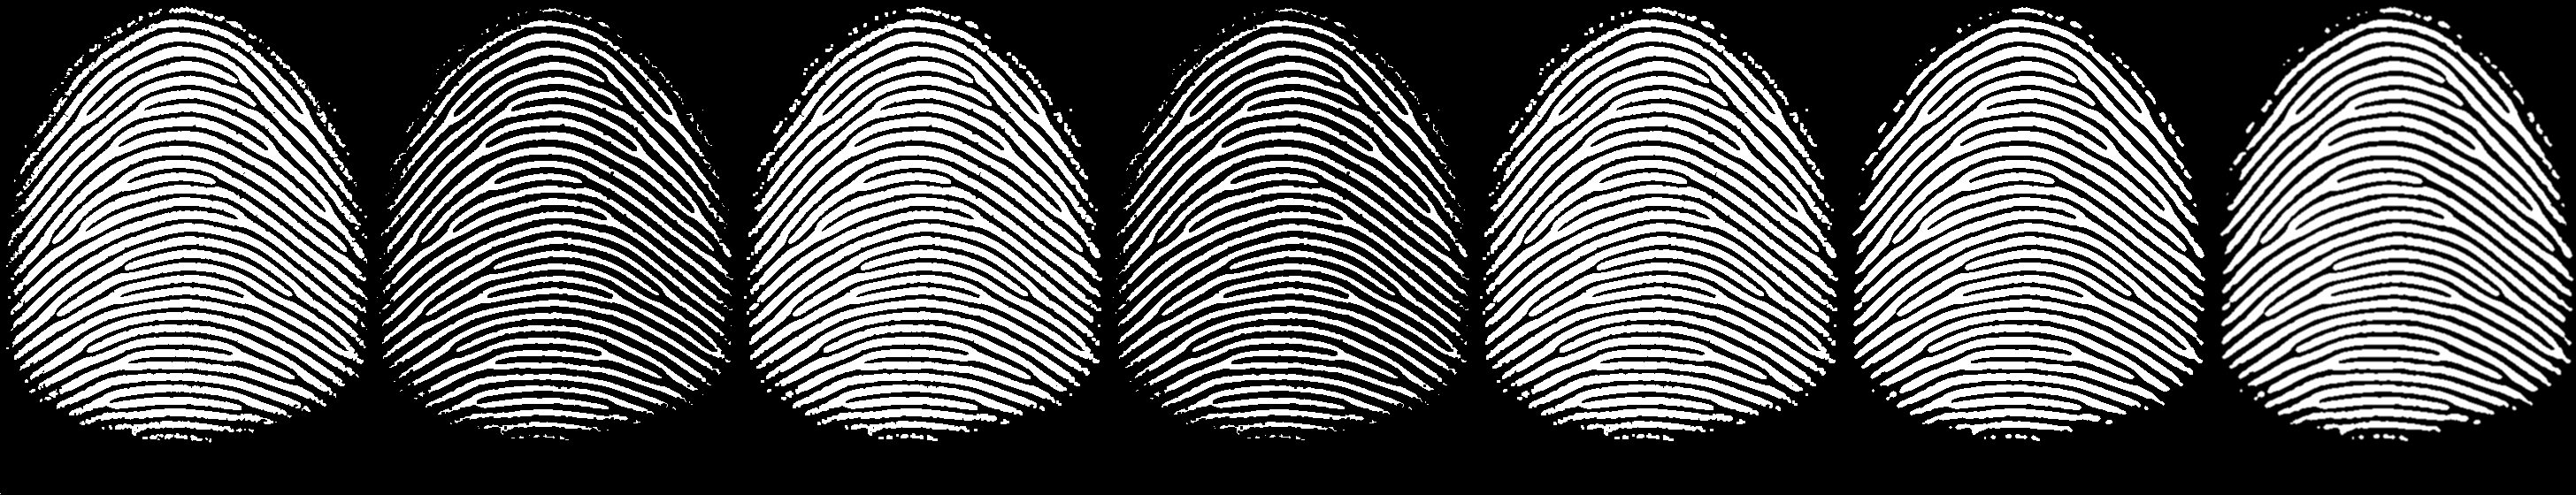

In [2]:
img = cv2.imread(root + "finger.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh, img_binary = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_binary = cv2.bitwise_not(img_binary)

kernel = np.ones((3,3), np.uint8)

erosion = cv2.erode(img_binary,kernel,iterations=1)
dilation = cv2.dilate(erosion,kernel,iterations=1) 
erosion2 = cv2.erode(dilation,kernel,iterations=1)
dilation2 = cv2.dilate(erosion2,kernel,iterations=1) 

median_filtered = cv2.medianBlur(dilation2,5)
blurred = cv2.GaussianBlur(median_filtered,(3,3),0)

image = img_as_bool(blurred)

cv2_imshow(cv2.hconcat([img_binary, erosion, dilation, erosion2, dilation2, median_filtered, blurred]))

# Post Morphological Operations

##Kernels

In [3]:
ridge_terminations_kernel = [
    np.array([[-1, 1,-1],
              [-1, 1,-1],
              [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1,-1],
              [-1, 1, 1],
              [-1,-1,-1]], dtype=np.int),

    np.array([[-1,-1,-1],
              [-1, 1,-1],
              [-1, 1,-1]], dtype=np.int),
    
    np.array([[-1,-1,-1],
              [ 1, 1,-1],
              [-1,-1,-1]], dtype=np.int),
    
    np.array([[ 1,-1,-1],
              [-1, 1,-1],
              [-1,-1,-1]], dtype=np.int),
        
    np.array([[-1,-1, 1],
              [-1, 1,-1],
              [-1,-1,-1]], dtype=np.int),
    
    np.array([[-1,-1,-1],
              [-1, 1,-1],
              [-1,-1, 1]], dtype=np.int),
    
    np.array([[-1,-1,-1],
              [-1, 1,-1],
              [ 1,-1,-1]], dtype=np.int)]

ridge_bifurcations_kernel = [
    np.array([[-1,-1, 1],
              [ 1, 1,-1],
              [-1,-1, 1]], dtype=np.int),

    np.array([[-1, 1,-1],
              [-1, 1,-1],
              [ 1,-1, 1]], dtype=np.int),

    np.array([[ 1,-1,-1],
              [-1, 1, 1],
              [ 1,-1,-1]], dtype=np.int),
    
    np.array([[ 1,-1, 1],
              [-1, 1,-1],
              [-1, 1,-1]], dtype=np.int),
    
    np.array([[-1, 1,-1],
              [-1, 1, 1],
              [ 1,-1,-1]], dtype=np.int),
        
    np.array([[ 1,-1,-1],
              [-1, 1, 1],
              [-1, 1,-1]], dtype=np.int),
    
    np.array([[-1,-1, 1],
              [ 1, 1,-1],
              [-1, 1,-1]], dtype=np.int),
    
    np.array([[-1, 1,-1],
              [ 1, 1,-1],
              [-1,-1, 1]], dtype=np.int)]

##Ridge

In [4]:
def extract_ridge(input_img, kernel):
    img = input_img.copy()
    result = np.zeros(img.shape, dtype=np.uint8)
    for i in kernel:
        result = cv2.bitwise_or(result, cv2.morphologyEx(img, cv2.MORPH_HITMISS, i))
    return result  

##PostProcessing

###Get minutiae list

In [5]:
def get_minutiae_list(minutiae_img):
    minutiae = []
    (ik, jk) = minutiae_img.shape
    for i in range(ik):
        for j in range(jk):
            if minutiae_img[i][j] != 0:
                minutiae.append((i,j))
    return minutiae

### Mask with distance

In [6]:
def mask(minutiae_list, tresh):
    result = minutiae_list.copy()
    for m1 in minutiae_list:
        for m2 in minutiae_list:
            if m1 != m2 and manhattan_dist(m1, m2) < tresh:
                if m1 in result:
                    result.remove(m1)
                if m2 in result:
                    result.remove(m2)
    return result

###PostProcessing

In [7]:
def postprocessing(terminations_img, bifurcations_img, tresh1 = 30, tresh2 = 30):
    terminations_list = get_minutiae_list(terminations_img)
    bifurcations_list = get_minutiae_list(bifurcations_img)
    terminations_list = mask(terminations_list, tresh1)
    bifurcations_list = mask(bifurcations_list, tresh2)
    return terminations_list, bifurcations_list

## Show minutiae

In [8]:
def show_minut(terminations_list, bifurcations_list):
    show_minutiae = img_gray.copy()
    show_minutiae = cv2.cvtColor(show_minutiae, cv2.COLOR_GRAY2BGR)
    for (i,j) in terminations_list:
        drawed_minutiae = cv2.circle(show_minutiae,(j,i), 4, (0,0,255))
    for (i,j) in bifurcations_list:
        drawed_minutiae = cv2.circle(show_minutiae,(j,i), 4, (255,255,0))
    return drawed_minutiae

# Creating Dataset

In [9]:
def dataset(terminations_list, bifurcations_list):
  list_termi_x = []
  list_termi_y = []
  list_bifur_x = []
  list_bifur_y = []
  count_ter = 0
  count_bifur = 0
  list_termi = []
  list_bifur = []
  for (i,j) in terminations_list:
    count_ter +=1
    list_termi_x.append(i)
    list_termi_y.append(j)
    list_termi.append(f"Ending{count_ter}")
  for (i,j) in bifurcations_list:
    count_bifur +=1
    list_bifur_x.append(i)
    list_bifur_y.append(j)
    list_bifur.append(f"Bifurcation{count_bifur}")

  min_type_arr = np.concatenate((np.array(list_termi), np.array(list_bifur)))
  x_coor_arr = np.concatenate((np.array(list_termi_x),np.array(list_bifur_x)))
  y_coor_arr = np.concatenate((np.array(list_termi_y),np.array(list_bifur_y)))

  min_type_df = pd.DataFrame(min_type_arr, columns=["Minutiae type"])
  x_coor_df = pd.DataFrame(x_coor_arr, columns=["x coordinate"])
  y_coor_df = pd.DataFrame(y_coor_arr, columns=["y coordinate"])
  
  df = pd.concat([min_type_df, x_coor_df, y_coor_df], axis=1)

  return df

#Main

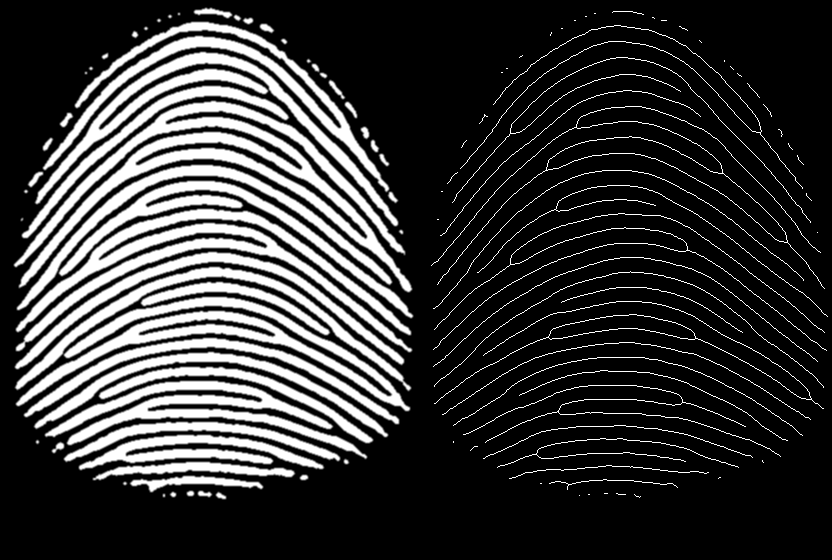

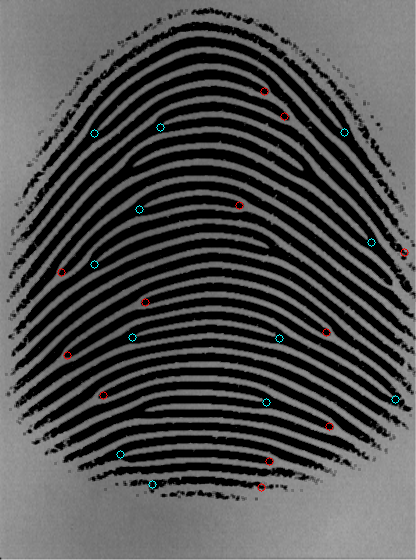

    Minutiae type  x coordinate  y coordinate
0         Ending1            91           264
1         Ending2           116           284
2         Ending3           205           239
3         Ending4           252           404
4         Ending5           272            61
5         Ending6           302           145
6         Ending7           332           326
7         Ending8           355            67
8         Ending9           395           103
9        Ending10           426           329
10       Ending11           461           269
11       Ending12           487           261
12   Bifurcation1           127           160
13   Bifurcation2           132           344
14   Bifurcation3           133            94
15   Bifurcation4           209           139
16   Bifurcation5           242           371
17   Bifurcation6           264            94
18   Bifurcation7           337           132
19   Bifurcation8           338           279
20   Bifurcation9           399   

In [11]:
if __name__ == "__main__":
    out = skeletonize(image)
    out = out.astype("uint8")*255
    cv2_imshow(cv2.hconcat([blurred, out]))

    bifurcations = extract_ridge(out, ridge_bifurcations_kernel)
    terminations = extract_ridge(out, ridge_terminations_kernel)
    terminations_list, bifurcations_list = postprocessing(terminations, bifurcations)
    drawed_minutiae = show_minut(terminations_list, bifurcations_list)
    df = dataset(terminations_list, bifurcations_list)
    #df.to_csv(root + 'minutiae.csv', index=False)
    cv2_imshow(drawed_minutiae)
    print(df)